# Ulepszanie wydajności klasyfikatorów

Wydajność modeli można zwiększać poprzez:

- dostrajanie parametrów pojedynczego modelu w celu jego ulepszenia. Do automatycznego dostrajania parametrów modelu w R można użyć pakietu `caret`. Pełna lista metod (algorytmów uczenia maszynowego) i ich dostosowywalnych parametrów znajduje się na [stronie internetowej](http://topepo.github.io/caret/available-models.html).

- łączenie ze sobą kilku słabych modeli w celu utworzenia lepszej jednostki. Jest to tak zwane uczenie zespołowe (ang. *ensemble learning*), któremu poświęcone są dzisiejsze ćwiczenia.

## Metody zespołowe

Podstawowe założenie: zaangażowanie zespołu różnych ekspertów (modeli) we wspólne rozwiązywanie problemu podniesie wydajność uczenia.

### Bagging

Jedna z najpopularniejszych technik uczenia zespołowego. Nazwa pochodzi od *bootstrap aggregating* - technika bagging wykorzystuje próbkowanie metodą bootstrap w funkcji alokacji do generowania danych przypisywanych do każdego z modeli w zespole. Zespoły w agregacji bootstrap zazwyczaj składają się z jednorodnych klasyfikatorów, które są trenowane równolegle i niezależnie od siebie.
Wśród metod bagging jedną z najpopularniejszych są *lasy losowe* (ang. *random forest*), składające się z wielu klasyfikatorów drzew decyzyjnych. Funkcja alokacji lasów łączy próbkowanie metodą bootstrap z losowym wybieraniem cech do generowania danych przydzielanych każdemu z klasyfikatorów w zespole. Lasy losowe nadają się do obsługiwania bardzo szerokich zbiorów danych.

### Boosting

Zespoły Wzmacniające (ang. *boosting*) są również jednorodnymi zbiorami podstawowych modeli. W odróżnieniu od agregacji bootstrap, we wzmacnianiu podstawowe modele są trenowane sekwencyjnie. Każdy kolejny model w sekwencji próbuje osiągnąć większą wydajność od poprzedniego modelu, ucząc się na błędach poprzednika. Następnie przeprowadzane jest wtórne próbkowanie danych treningowych tak, że przykładom dla których były nieprawidłowe predykcje, otrzymują większą wagę.

Proces wtórnego próbkowania, trenowania, oceniania i punktowania jest powtarzany do każdego modelu w sekwencji, dopóki wszystkie modele nie zostaną wytrenowane.

### Stacking

Stacking, czyli kontaminacja modeli, różni się od poprzednich dwóch tym, że zawiera tu zwykle różnorodne modele podstawowe. Przykładowo może składać się z modelu kNN, modelu regresji logistycznej oraz naiwnego modelu Bayesa. Kontaminacja modeli jest podobna do agregacji bootstrap, tyle że funkcja kombinacji jest tutaj niedeterministyczna (nie przebiega zgodnie z predefiniowanym wzorcem czy zbiorem reguł).

Zazponaj się z materiałami zamieszczonymi na stronie [RPubs](https://rpubs.com/mmazurek/346331), sekcje:

- Klasyfikatory złożone

- Agregacja bootstrapowa (bagging - bootstrap aggregation)

- Lasy losowe

- Boosting
  - Adaboost - adaptive boosting

Następnie wykonaj poniższe zadania.

## Zadania

1.	Pobierz i wczytaj w RStudio plik z danymi `Movie_classification.csv`. Celem zadania jest przewidzenie, czy dany film otrzyma Oskara czy też nie (zmienna dychotomiczna `Start_Tech_Oskar`).

In [1]:
library(tidyverse)
options(jupyter.rich_display = FALSE,
        repr.plot.width = 15,
        repr.plot.height = 8)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
df <- read_csv("data/Movie_classification.csv")
names(df) <- gsub(" ", "_", names(df))
names(df)[names(df) == '3D_available'] <- 'is_3D_available'

Rows: 506 Columns: 19
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): 3D_available, Genre
dbl (17): Marketing expense, Production expense, Multiplex coverage, Budget,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


2.	Przyglądnij się danym i przygotuj je do dalszej analizy:

 - braki danych zastąp wartością średnią dla danego atrybutu, 
 - za pomocą funkcji `sample.split` (z pakietu `caTools`) oraz `subset` podziel dane na zbiór treningowy i testowy.

In [3]:
names(df)

 [1] "Marketing_expense"   "Production_expense"  "Multiplex_coverage" 
 [4] "Budget"              "Movie_length"        "Lead__Actor_Rating" 
 [7] "Lead_Actress_rating" "Director_rating"     "Producer_rating"    
[10] "Critic_rating"       "Trailer_views"       "is_3D_available"    
[13] "Time_taken"          "Twitter_hastags"     "Genre"              
[16] "Avg_age_actors"      "Num_multiplex"       "Collection"         
[19] "Start_Tech_Oscar"   

In [4]:
dim(df)

[1] 506  19

In [5]:
glimpse(df)

Rows: 506
Columns: 19
$ Marketing_expense   <dbl> 20.1264, 20.5462, 20.5458, 20.6474, 21.3810, 20.59…
$ Production_expense  <dbl> 59.62, 69.14, 69.14, 59.36, 59.36, 59.36, 70.74, 7…
$ Multiplex_coverage  <dbl> 0.462, 0.531, 0.531, 0.542, 0.542, 0.542, 0.476, 0…
$ Budget              <dbl> 36524.12, 35668.65, 39912.68, 38873.89, 39701.58, …
$ Movie_length        <dbl> 138.7, 152.4, 134.6, 119.3, 127.7, 132.2, 140.1, 1…
$ Lead__Actor_Rating  <dbl> 7.825, 7.505, 7.485, 6.895, 6.920, 6.890, 7.065, 6…
$ Lead_Actress_rating <dbl> 8.095, 7.650, 7.570, 7.035, 7.070, 7.100, 7.265, 7…
$ Director_rating     <dbl> 7.910, 7.440, 7.495, 6.920, 6.815, 6.885, 7.150, 6…
$ Producer_rating     <dbl> 7.995, 7.470, 7.515, 7.020, 7.070, 7.005, 7.400, 7…
$ Critic_rating       <dbl> 7.94, 7.44, 7.44, 8.26, 8.26, 7.26, 8.96, 7.96, 7.…
$ Trailer_views       <dbl> 527367, 494055, 547051, 516279, 531448, 498425, 45…
$ is_3D_available     <chr> "YES", "NO", "NO", "YES", "NO", "YES", "YES", "NO"…
$ Time_taken      

In [6]:
summary(df)

 Marketing_expense Production_expense Multiplex_coverage     Budget     
 Min.   :  20.13   Min.   : 55.92     Min.   :0.1290     Min.   :19781  
 1st Qu.:  21.64   1st Qu.: 65.38     1st Qu.:0.3760     1st Qu.:32694  
 Median :  25.13   Median : 74.38     Median :0.4620     Median :34488  
 Mean   :  92.27   Mean   : 77.27     Mean   :0.4453     Mean   :34911  
 3rd Qu.:  93.54   3rd Qu.: 91.20     3rd Qu.:0.5510     3rd Qu.:36794  
 Max.   :1799.52   Max.   :110.48     Max.   :0.6150     Max.   :48773  
                                                                        
  Movie_length   Lead__Actor_Rating Lead_Actress_rating Director_rating
 Min.   : 76.4   Min.   :3.840      Min.   :4.035       Min.   :3.840  
 1st Qu.:118.5   1st Qu.:7.316      1st Qu.:7.504       1st Qu.:7.296  
 Median :151.0   Median :8.307      Median :8.495       Median :8.312  
 Mean   :142.1   Mean   :8.014      Mean   :8.186       Mean   :8.020  
 3rd Qu.:167.6   3rd Qu.:8.865      3rd Qu.:9.030       

In [7]:
df <- df %>%
  mutate(
    Trailer_views = as.integer(Trailer_views),
    is_3D_available = is_3D_available == "YES",
    Genre = as.factor(Genre),
    Avg_age_actors = as.integer(Avg_age_actors),
    Num_multiplex = as.integer(Num_multiplex),
    Collection = as.integer(Collection),
    Start_Tech_Oscar = as.factor(Start_Tech_Oscar),
  )

In [8]:
df %>%
  filter(if_any(everything(), is.na)) %>%
  nrow()

[1] 12

In [9]:
sapply(df, function(x) sum(length(which(is.na(x)))))

  Marketing_expense  Production_expense  Multiplex_coverage              Budget 
                  0                   0                   0                   0 
       Movie_length  Lead__Actor_Rating Lead_Actress_rating     Director_rating 
                  0                   0                   0                   0 
    Producer_rating       Critic_rating       Trailer_views     is_3D_available 
                  0                   0                   0                   0 
         Time_taken     Twitter_hastags               Genre      Avg_age_actors 
                 12                   0                   0                   0 
      Num_multiplex          Collection    Start_Tech_Oscar 
                  0                   0                   0 

In [10]:
df["Time_taken"][is.na(df["Time_taken"])] <- as.integer(mean(df$Time_taken, na.rm = TRUE))

In [11]:
df %>%
  filter(if_any(everything(), is.na)) %>%
  nrow()

[1] 0

In [12]:
set.seed(2024)
split <- rsample::initial_split(df, prop = 0.75)

X_train <- rsample::training(split)
X_test <- rsample::testing(split)

y_train <- X_train$Start_Tech_Oscar
y_test <- X_test$Start_Tech_Oscar

In [13]:
prop.table(table(df["Start_Tech_Oscar"]))

Start_Tech_Oscar
        0         1 
0.4545455 0.5454545 

In [14]:
prop.table(table(y_train))

y_train
        0         1 
0.4511873 0.5488127 

3. Dokonaj klasyfikacji za pomocą trzech algorytmów złożonych: bagging, random forest oraz boosting (zbuduj modele na zbiorze treningowym).

*normal glm*

In [15]:
library(ROCR)
library(adabag)
library(ada)

Loading required package: rpart

Loading required package: caret

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


Loading required package: foreach


Attaching package: ‘foreach’


The following objects are masked from ‘package:purrr’:

    accumulate, when


Loading required package: doParallel

Loading required package: iterators

Loading required package: parallel



*zwykla regresja logistyczna*

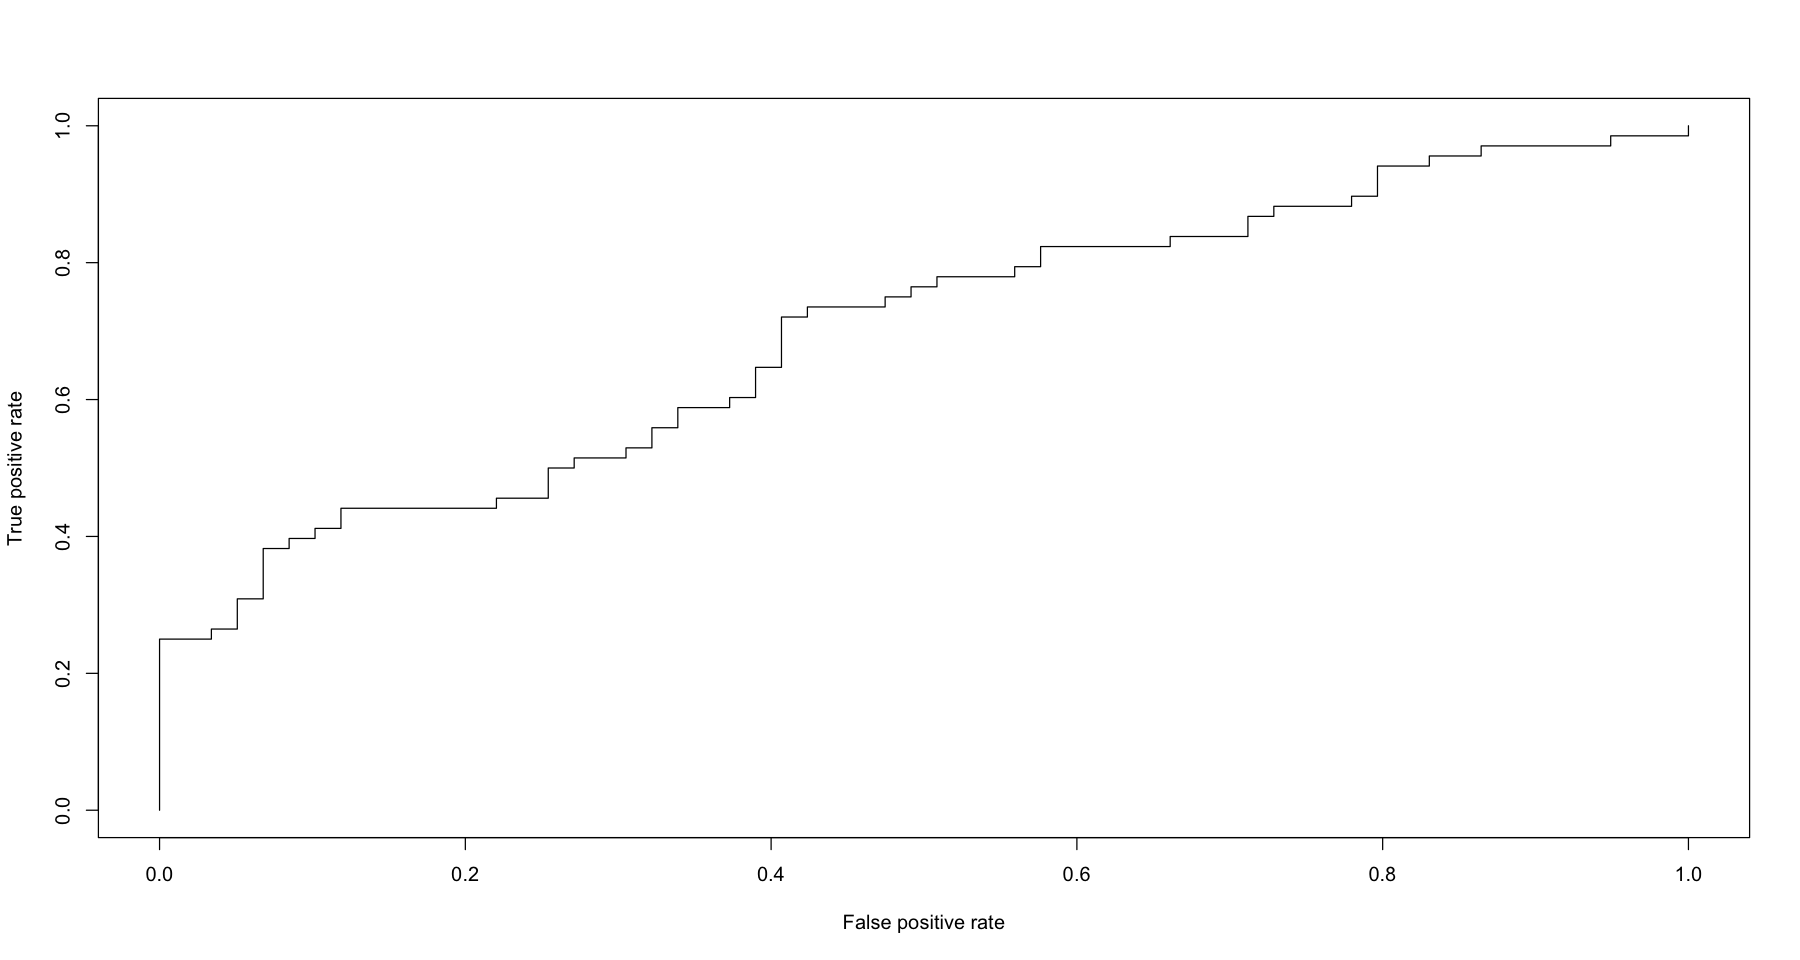

In [16]:
logistic_model <- glm(Start_Tech_Oscar ~ ., 
                      family = binomial, 
                      data = X_train)

y_pred_proba <- predict(logistic_model, 
                  type = "response",  
                  newdata = X_test)

pred = prediction(y_pred_proba, y_test)
perf <- performance(pred, "tpr", "fpr")
plot(perf)

In [17]:
cat("AUC")
performance(pred, measure = "auc")@y.values[[1]]

AUC

[1] 0.6964108

In [18]:
y_pred <- as.factor(as.vector(ifelse(y_pred_proba < 0.5, 0, 1)))
caret::confusionMatrix(y_pred, y_test)

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 33 18
         1 26 50
                                         
               Accuracy : 0.6535         
                 95% CI : (0.564, 0.7357)
    No Information Rate : 0.5354         
    P-Value [Acc > NIR] : 0.004634       
                                         
                  Kappa : 0.2973         
                                         
 Mcnemar's Test P-Value : 0.291293       
                                         
            Sensitivity : 0.5593         
            Specificity : 0.7353         
         Pos Pred Value : 0.6471         
         Neg Pred Value : 0.6579         
             Prevalence : 0.4646         
         Detection Rate : 0.2598         
   Detection Prevalence : 0.4016         
      Balanced Accuracy : 0.6473         
                                         
       'Positive' Class : 0              
                                         

___
*bagging*

In [19]:
library(foreach)

In [20]:
# for loop doing k iterations
iterations <- 100
predictions <- foreach(i = 1:iterations) %do% {
  
    # train test split
    split_bagg <- rsample::initial_split(df, prop = 0.75)

    X_train_bagg <- rsample::training(split_bagg)
    X_test_bagg <- rsample::testing(split_bagg)

    y_train_bagg <- X_train_bagg$Start_Tech_Oscar
    y_test_bagg <- X_test_bagg$Start_Tech_Oscar

    # model creation
    logistic_model_bagg <- glm(Start_Tech_Oscar ~ ., 
                      family = binomial, 
                      data = X_train_bagg)

    # class prediction
    y_pred_proba_bagg <- predict(logistic_model_bagg, 
                    type = "response",  
                    newdata = X_test_bagg)
    y_pred_bagg <- ifelse(y_pred_proba_bagg < 0.5, 0, 1)

    # calculate accuracy
    accuracy <- mean(y_pred_bagg == y_test_bagg)
    if(iterations <= 25) print(glue::glue("{i} accuracy:{round(accuracy, 2)}"))
    result<-list(accuracy, logistic_model)
    result
}

acc = lapply(predictions, function(l) l[[1]])
acc_vector<-unlist(acc)
mean(acc_vector)

[1] 0.6208661

In [21]:
models = lapply(predictions, function(l) l[[2]])
pred2 <- lapply(models, function(x) predict(x, type = "response",  newdata = X_test))
pred_df <- data.frame(pred2)

colnames(pred_df) <- paste('classifier_', 1:iterations)
pred_matrix <- as.matrix(pred_df)

class_matrix <- ifelse(pred_matrix< 0.5, 0, 1)
final_pred <- ifelse(rowMeans(class_matrix) < 0.5, 0, 1)

accuracy <- mean(final_pred == y_test)
accuracy 

[1] 0.6535433

*wynik zblizony od rezultatu pojedynczej iteracji, moze cos zrobilem zle ale wydaje sie ze jest dobrze*

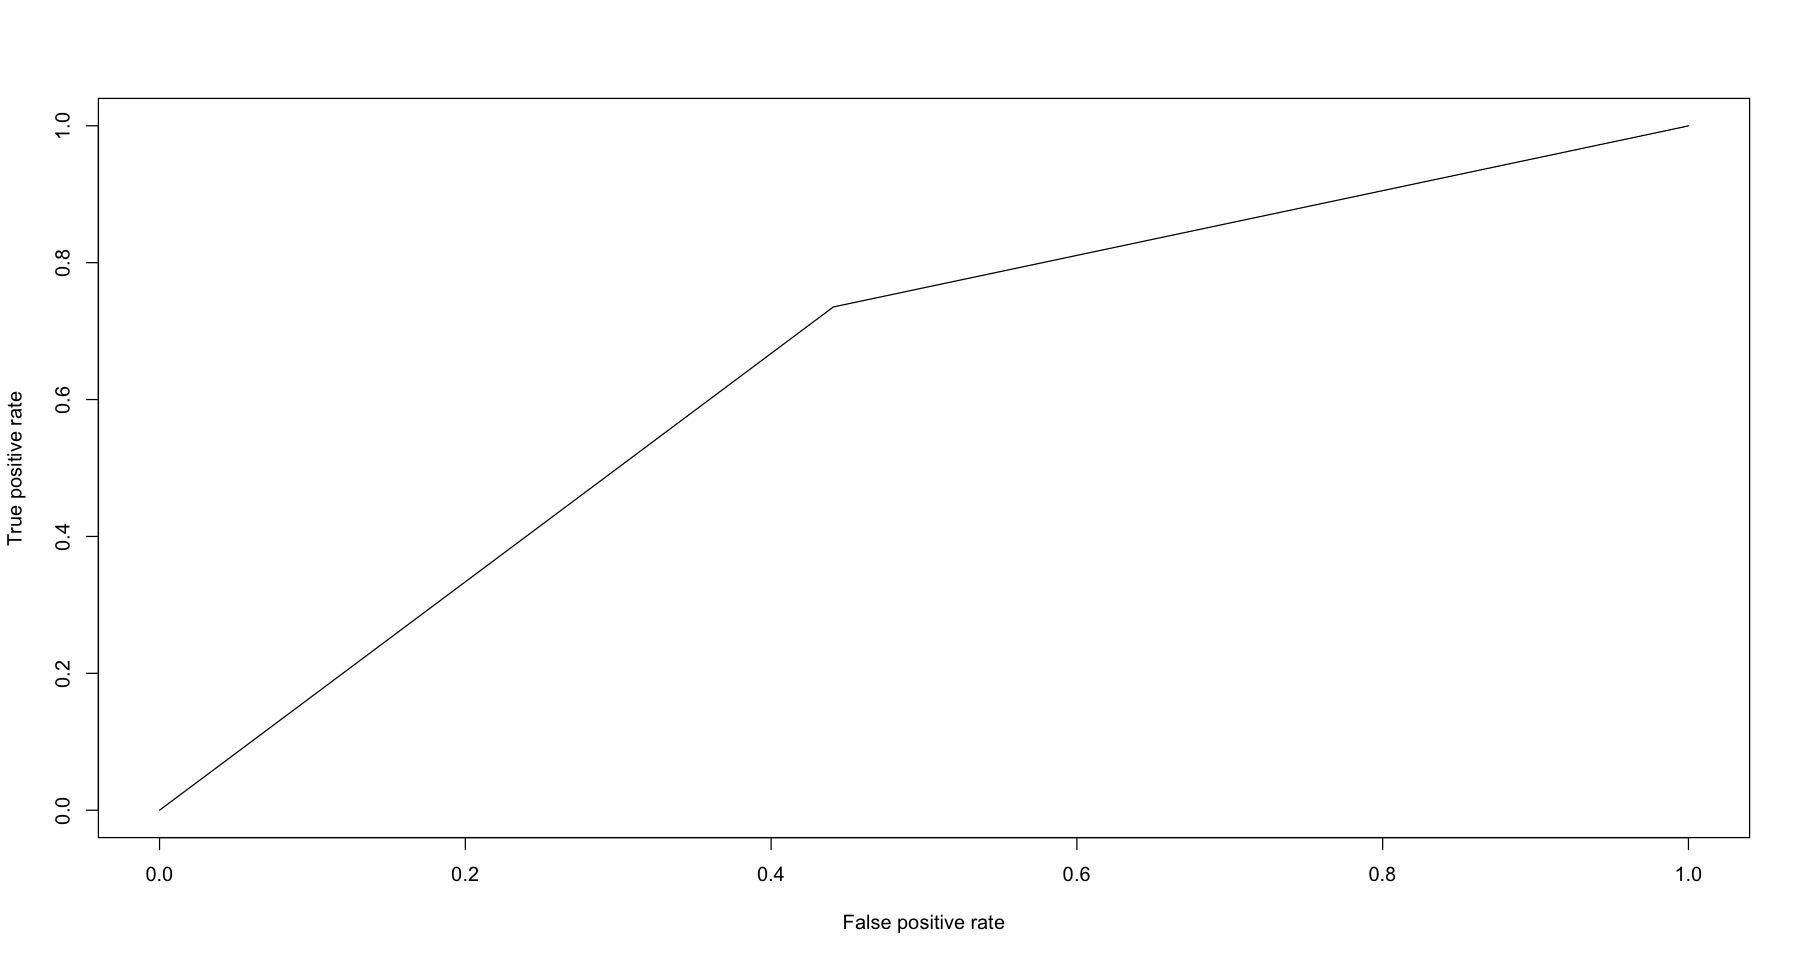

In [22]:
pred = prediction(rowMeans(class_matrix), y_test)
perf <- performance(pred, "tpr", "fpr")
plot(perf)

In [23]:
AUCLog1=performance(pred, measure = "auc")@y.values[[1]]
cat("AUC: ",AUCLog1)

AUC:  0.6473081

___
*decision tree*

In [24]:
library(ipred)  #bagging for classification trees 
library(rpart)


Attaching package: ‘ipred’


The following object is masked from ‘package:adabag’:

    bagging




In [25]:
set.seed(2024)
tree_model_bagg <- bagging(Start_Tech_Oscar ~.,
                           data=X_train,
                           mfinal=15) 


In [26]:
y_pred <-predict(tree_model_bagg, X_test)

In [27]:
library(e1071)
library(caret)

In [28]:
y_test

  [1] 0 1 1 1 0 0 0 1 0 0 1 0 1 1 1 1 0 1 0 0 1 0 0 1 0 0 0 1 1 0 0 1 1 1 1 1 0
 [38] 0 0 0 0 0 0 1 1 1 1 0 1 0 0 0 0 0 1 1 0 0 1 1 0 1 1 1 1 1 0 0 0 0 0 0 1 1
 [75] 1 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1
[112] 1 0 0 1 1 0 1 1 0 1 1 1 0 0 1 0
Levels: 0 1

In [29]:
y_pred

  [1] 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 1 1 1 0 0
 [38] 1 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 1 1 1 0 1 1 0 0 1 1 0 1 0 1 1 1 1 0 0 1 1
 [75] 0 1 0 1 0 0 0 0 0 1 0 0 0 1 1 1 0 1 1 1 1 1 1 0 0 1 0 0 0 0 0 0 0 1 1 1 1
[112] 0 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0
Levels: 0 1

In [30]:
caret::confusionMatrix(y_pred, y_test, '1')

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 35 26
         1 24 42
                                          
               Accuracy : 0.6063          
                 95% CI : (0.5157, 0.6918)
    No Information Rate : 0.5354          
    P-Value [Acc > NIR] : 0.06472         
                                          
                  Kappa : 0.2104          
                                          
 Mcnemar's Test P-Value : 0.88754         
                                          
            Sensitivity : 0.6176          
            Specificity : 0.5932          
         Pos Pred Value : 0.6364          
         Neg Pred Value : 0.5738          
             Prevalence : 0.5354          
         Detection Rate : 0.3307          
   Detection Prevalence : 0.5197          
      Balanced Accuracy : 0.6054          
                                          
       'Positive' Class : 1               
                                    

___
*random forest*

In [31]:
library(randomForest)
library(rsample)

randomForest 4.7-1.2

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin



Attaching package: ‘rsample’


The following object is masked from ‘package:e1071’:

    permutations




In [32]:
set.seed(2024)

# split
split_rf <- rsample::initial_split(df, prop = 0.75)
X_train_rf <- rsample::training(split_rf)
X_test_rf <- rsample::testing(split_rf)

y_train_rf <- X_train_rf$Start_Tech_Oscar
y_test_rf <- X_test_rf$Start_Tech_Oscar

X_train_rf_predictors <- X_train_rf[, !names(X_train_rf) %in% "Start_Tech_Oscar"]
X_test_rf_predictors <- X_test_rf[, !names(X_test_rf) %in% "Start_Tech_Oscar"]

# model
rf_model <- randomForest(x = X_train_rf_predictors, 
                         y = as.factor(y_train_rf), 
                         ntree = 500, 
                         importance = TRUE)

# pred
y_pred_rf <- predict(rf_model, newdata = X_test_rf_predictors)

# accuracy
accuracy <- mean(y_pred_rf == y_test_rf)

# Wyświetlenie wyniku
cat("Accuracy Random Forest:", round(accuracy, 4), "\n")

Accuracy Random Forest: 0.5748 


In [33]:
glimpse(df)

Rows: 506
Columns: 19
$ Marketing_expense   <dbl> 20.1264, 20.5462, 20.5458, 20.6474, 21.3810, 20.59…
$ Production_expense  <dbl> 59.62, 69.14, 69.14, 59.36, 59.36, 59.36, 70.74, 7…
$ Multiplex_coverage  <dbl> 0.462, 0.531, 0.531, 0.542, 0.542, 0.542, 0.476, 0…
$ Budget              <dbl> 36524.12, 35668.65, 39912.68, 38873.89, 39701.58, …
$ Movie_length        <dbl> 138.7, 152.4, 134.6, 119.3, 127.7, 132.2, 140.1, 1…
$ Lead__Actor_Rating  <dbl> 7.825, 7.505, 7.485, 6.895, 6.920, 6.890, 7.065, 6…
$ Lead_Actress_rating <dbl> 8.095, 7.650, 7.570, 7.035, 7.070, 7.100, 7.265, 7…
$ Director_rating     <dbl> 7.910, 7.440, 7.495, 6.920, 6.815, 6.885, 7.150, 6…
$ Producer_rating     <dbl> 7.995, 7.470, 7.515, 7.020, 7.070, 7.005, 7.400, 7…
$ Critic_rating       <dbl> 7.94, 7.44, 7.44, 8.26, 8.26, 7.26, 8.96, 7.96, 7.…
$ Trailer_views       <int> 527367, 494055, 547051, 516279, 531448, 498425, 45…
$ is_3D_available     <lgl> TRUE, FALSE, FALSE, TRUE, FALSE, TRUE, TRUE, FALSE…
$ Time_taken      

In [34]:
library(xgboost)
library(caret)

set.seed(2024)

# split
split_boost <- rsample::initial_split(df, prop = 0.75)
X_train_boost <- rsample::training(split_boost)
X_test_boost <- rsample::testing(split_boost)

y_train_boost <- as.numeric(X_train_boost$Start_Tech_Oscar) - 1
y_test_boost <- as.numeric(X_test_boost$Start_Tech_Oscar) - 1

# select
X_train_boost_predictors <- X_train_boost %>% 
  select(-Start_Tech_Oscar)

X_test_boost_predictors <- X_test_boost %>% 
  select(-Start_Tech_Oscar)

# encode nonumerics
dummyVars <- dummyVars(~ ., data = rbind(X_train_boost_predictors, X_test_boost_predictors))
X_train_matrix <- predict(dummyVars, newdata = X_train_boost_predictors)
X_test_matrix <- predict(dummyVars, newdata = X_test_boost_predictors)

X_train_matrix <- as.matrix(X_train_matrix)
X_test_matrix <- as.matrix(X_test_matrix)

dtrain <- xgb.DMatrix(data = X_train_matrix, label = y_train_boost)
dtest <- xgb.DMatrix(data = X_test_matrix, label = y_test_boost)

# parameters
params <- list(
  booster = "gbtree",
  objective = "binary:logistic",
  eta = 0.1,
  max_depth = 6,
  eval_metric = "auc"
)

# model
boost_model <- xgb.train(
  params = params,
  data = dtrain,
  nrounds = 100,
  verbose = FALSE
)

# prediction
y_pred_proba_boost <- predict(boost_model, dtest)
y_pred_boost <- ifelse(y_pred_proba_boost > 0.5, 1, 0)

# accuracy
accuracy <- mean(y_pred_boost == y_test_boost)
cat("Accuracy Boosting:", round(accuracy, 4), "\n")


Attaching package: ‘xgboost’


The following object is masked from ‘package:dplyr’:

    slice




Accuracy Boosting: 0.6142 


4. Sprawdź jak dobrze utworzone modele radzą sobie z danymi testowymi (użyj funkcji `confusionMatrix` z pakietu `caret`). Jaki procent danych został poprawnie zaklasyfikowany? Który model okazał się w tym przypadku najlepszy?

*zwykly model glm oraz ten zbaggowany maja najlepsze wyniki 65% dokladnosci, drzewa w tym wypadku nie poradzily sobie dobrze, ale moze warto jest pobawic sie paramterami bo byly odpalane na defaultowych*

In [35]:
# EOF